In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import numpy as np

# Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# ML imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import RMSprop

# Reweighting Schemes

In [3]:
N = 10**6 # Sample size
mu = 0.1
sigma = 1

In [4]:
### Generate the data.

# Background is Normal(-μ, 1)
# Signal is Normal(μ, 1))
bkgd = np.random.normal(-mu, sigma, N)
sgnl = np.random.normal(mu, sigma, N)
X = np.concatenate([bkgd, sgnl])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
earlystopping = EarlyStopping(patience=10,
                              verbose=0,
                              restore_best_weights=True)

ensemble_size = 1000

In [6]:
# Loss functions
def bce(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * K.log(1. - y_pred))

def mse(y_true, y_pred):
    return -((y_true) * -K.square(1. - y_pred) + (1. - y_true) * -K.square(y_pred + K.epsilon()))

def sqr(y_true, y_pred):    
    return -((y_true) * -1. / K.sqrt(y_pred + K.epsilon()) + (1. - y_true) * -K.sqrt(y_pred + K.epsilon()))

def mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * (1. - y_pred))

# Models
def train(loss):
    # Should I generate new data each time? No.
    match_params = {'bce': ['relu', 'relu', 'relu', 'sigmoid', bce, 'adam', 2],
                    'mse': ['relu', 'relu', 'relu', 'sigmoid', mse, 'adam', 2],
                    'sqr': ['relu', 'relu', 'relu', 'relu', sqr, RMSprop(lr=1e-5, momentum=1), 2],
                    'mlc': ['relu', 'relu', 'relu', 'relu', mlc, 'rmsprop', 0.5]}
    params = match_params[loss]
    
    i = 1
    while True:
        print('Training {}: '.format(i) + loss.upper())
        i += 1
        inputs = Input((1, ))
        layer_1 = Dense(64, activation=params[0])(inputs)
        layer_2 = Dense(128, activation=params[1])(layer_1)
        layer_3 = Dense(64, activation=params[2])(layer_2)
        outputs = Dense(1, activation=params[3])(layer_3)
        
        model = Model(inputs=inputs, outputs = outputs)
        model.compile(loss=params[4], 
                      optimizer=params[5], 
                      metrics='accuracy')
        
        trace = model.fit(X_train, 
                          y_train, 
                          epochs = 100, 
                          batch_size=int(0.1*N), 
                          validation_data=(X_test, y_test), 
                          callbacks=[earlystopping], 
                          verbose=0)
        
        if trace.history['val_loss'][-1] < params[6]:
            return model
        
# Likelihood ratios
def lr(x):
    return np.exp(-0.5*( (x - mu)**2 - (x + mu)**2))

def get_bce_lr(model):
    def model_bce_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_bce_lr

def get_mse_lr(model):
    def model_mse_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_mse_lr

def get_sqr_lr(model):
    def model_sqr_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_sqr_lr

def get_mlc_lr(model):
    def model_mlc_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_mlc_lr

In [7]:
# Train models
ensemble_bce = []
ensemble_mse = []
ensemble_sqr = []
ensemble_mlc = []

print('==================================================')
for _ in range(ensemble_size):
    print(_, end = ' ')
    ensemble_bce += [train('bce')]

print('==================================================')
for _ in range(ensemble_size):
    print(_, end = ' ')
    ensemble_mse += [train('mse')]

print('==================================================')
for _ in range(ensemble_size):
    print(_, end = ' ')
    ensemble_sqr += [train('sqr')]      

print('==================================================')
for _ in range(ensemble_size):
    print(_, end = ' ')
    ensemble_mlc += [train('mlc')]

0 Training 1: BCE
1 Training 1: BCE
2 Training 1: BCE
3 Training 1: BCE
4 Training 1: BCE
5 Training 1: BCE
6 Training 1: BCE
7 Training 1: BCE
8 Training 1: BCE
9 Training 1: BCE
10 Training 1: BCE
11 Training 1: BCE
12 Training 1: BCE
13 Training 1: BCE
14 Training 1: BCE
15 Training 1: BCE
16 Training 1: BCE
17 Training 1: BCE
18 Training 1: BCE
19 Training 1: BCE
20 Training 1: BCE
21 Training 1: BCE
22 Training 1: BCE
23 Training 1: BCE
24 Training 1: BCE
25 Training 1: BCE
26 Training 1: BCE
27 Training 1: BCE
28 Training 1: BCE
29 Training 1: BCE
30 Training 1: BCE
31 Training 1: BCE
32 Training 1: BCE
33 Training 1: BCE
34 Training 1: BCE
35 Training 1: BCE
36 Training 1: BCE
37 Training 1: BCE
38 Training 1: BCE
39 Training 1: BCE
40 Training 1: BCE
41 Training 1: BCE
42 Training 1: BCE
43 Training 1: BCE
44 Training 1: BCE
45 Training 1: BCE
46 Training 1: BCE
47 Training 1: BCE
48 Training 1: BCE
49 Training 1: BCE
50 Training 1: BCE
51 Training 1: BCE
52 Training 1: BCE
53 

We need to make the below plots, but with average neural networks instead of a particular one.

In [18]:
for i in range(ensemble_size):
    ensemble_bce[i].save_weights('models/ratios/bce/bce_model_{}.h5'.format(i))
    ensemble_mse[i].save_weights('models/ratios/mse/mse_model_{}.h5'.format(i))
    ensemble_sqr[i].save_weights('models/ratios/sqr/sqr_model_{}.h5'.format(i))
    ensemble_mlc[i].save_weights('models/ratios/mlc/mlc_model_{}.h5'.format(i))

In [25]:
# Calculate average predictions.
bce_lrs = np.array([get_bce_lr(model)(xs) for model in ensemble_bce])
mse_lrs = np.array([get_mse_lr(model)(xs) for model in ensemble_mse])
sqr_lrs = np.array([get_sqr_lr(model)(xs) for model in ensemble_sqr])
mlc_lrs = np.array([get_mlc_lr(model)(xs) for model in ensemble_mlc])

bce_mean = bce_lrs.mean(axis=0)
mse_mean = mse_lrs.mean(axis=0)
sqr_mean = sqr_lrs.mean(axis=0)
mlc_mean = mlc_lrs.mean(axis=0)

bce_err = bce_lrs.std(axis=0)
mse_err = mse_lrs.std(axis=0)
sqr_err = sqr_lrs.std(axis=0)
mlc_err = mlc_lrs.std(axis=0)

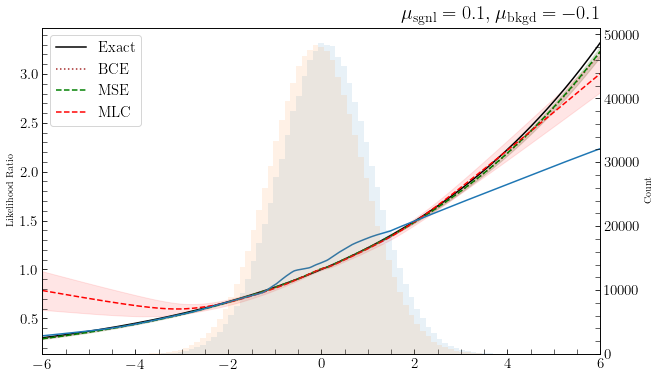

In [39]:
#xs = np.linspace(-6, 6, 1000)

fig, ax_1 = plt.subplots(figsize = (10, 6))

plt.plot(xs, lr(xs), label = 'Exact', c='k', ls='-')
plt.plot(xs, bce_mean, label = 'BCE', c='brown', ls=':')
plt.plot(xs, mse_mean, label = 'MSE', c='green', ls='--')
#plt.plot(xs, sqr_mean, label = 'SQR', c='blue', ls='-.')
plt.plot(xs, mlc_mean, label = 'MLC', c='red', ls='--')

plt.fill_between(xs, bce_mean - bce_err, bce_mean + bce_err, color='brown', alpha=0.1)
plt.fill_between(xs, mse_mean - mse_err, mse_mean + mse_err, color='green', alpha=0.1)
#plt.fill_between(xs, sqr_mean - sqr_err, sqr_mean + sqr_err, color='blue', alpha=0.1)
plt.fill_between(xs, mlc_mean - mlc_err, mlc_mean + mlc_err, color='red', alpha=0.1)

plt.legend()
ax_1.minorticks_on()
ax_1.tick_params(direction='in', which='both',length=5)
plt.ylabel('Likelihood Ratio')

ax_2 = ax_1.twinx()
bins = np.linspace(-6, 6, 100)
plt.hist(sig, alpha=0.1, bins=bins)
plt.hist(bgd, alpha=0.1, bins=bins)
ax_2.minorticks_on()
ax_2.tick_params(direction='in', which='both',length=5)
plt.ylabel('Count')

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
#plt.savefig('plots/avg_lrs.png', dpi=1200, bbox_inches='tight')

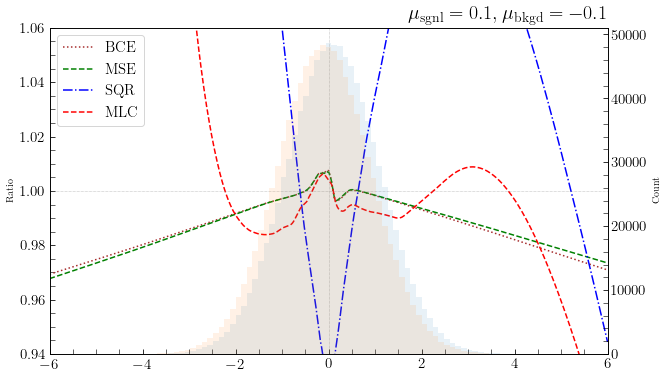

In [15]:
fig, ax_1 = plt.subplots(figsize = (10, 6))

plt.plot(xs, bce_lrs.mean(axis=0) / lr(xs), label = 'BCE', c = 'brown', ls=':')
plt.plot(xs, mse_lrs.mean(axis=0) / lr(xs), label = 'MSE', c = 'green', ls='--')
plt.plot(xs, sqr_lrs.mean(axis=0) / lr(xs), label = 'SQR', c = 'blue', ls='-.')
plt.plot(xs, mlc_lrs.mean(axis=0) / lr(xs), label = 'MLC', c = 'red', ls='--')
plt.axhline(1,ls=":",color="grey", lw=0.5)
plt.axvline(0,ls=":",color="grey", lw=0.5)
plt.legend()
ax_1.minorticks_on()
ax_1.tick_params(direction='in', which='both',length=5)
plt.ylim(0.94, 1.06)
plt.ylabel('Ratio')

ax_2 = ax_1.twinx()
bins = np.linspace(-6, 6, 100)
plt.hist(sgnl, alpha=0.1, bins=bins)
plt.hist(bkgd, alpha=0.1, bins=bins)
ax_2.minorticks_on()
ax_2.tick_params(direction='in', which='both',length=5)
plt.ylabel('Count')

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/avg_lr_ratios.png', dpi=1200, bbox_inches='tight')

In [10]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
Ns = 10**np.arange(1, 9)

In [ ]:
bce_models = {}
mse_models = {}
sqr_models = {}
mlc_models = {}

for N in Ns:
    print('===================================================\n{}'.format(N))
    # Set up lists
    bce_models[N] = []
    mse_models[N] = []
    sqr_models[N] = []
    mlc_models[N] = []
    
    # Generate data
    bkgd = np.random.normal(-mu, 1, N)
    sgnl = np.random.normal(mu, 1, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # BCE
    for _ in range(ensemble_size):
        print(_, end = ' ')
        bce_models[N] += [train('bce')]
    
    # MSE
    for _ in range(100):
        print(_, end = ' ')
        mse_models[N] += [train('mse')]
    
    # SQR
    for _ in range(100):
        print(_, end = ' ')
        sqr_models[N] += [train('sqr')]
    
    # MLC
    for _ in range(100):
        print(_, end = ' ')
        mlc_models[N] += [train('mlc')]

In [ ]:
for N in Ns:
    for i in range(ensemble_size):
        bce_models[N][i].save_weights('models/maes/bce/bce_model_{}_{}.h5'.format(N, i))
        mse_models[N][i].save_weights('models/maes/mse/mse_model_{}_{}.h5'.format(N, i))
        sqr_models[N][i].save_weights('models/maes/sqr/sqr_model_{}_{}.h5'.format(N, i))
        mlc_models[N][i].save_weights('models/maes/mlc/mlc_model_{}_{}.h5'.format(N, i))

In [ ]:
# Calculate mean absolute errors.

N = 10**6

bkgd = np.random.normal(-mu, 1, N)
sgnl = np.random.normal(mu, 1, N)
X = np.concatenate([bkgd, sgnl])

bce_maes = []
mse_maes = []
sqr_maes = []
mlc_maes = []
for i in range(len(Ns)):
    model_bce_lr = get_bce_lr(bce_models[i])
    bce_maes += [np.mean(np.abs(model_bce_lr(X) - lr(X)))]
    
    model_mse_lr = get_mse_lr(mse_models[i])
    mse_maes += [np.mean(np.abs(model_mse_lr(X) - lr(X)))]
    
    model_sqr_lr = get_sqr_lr(sqr_models[i])
    sqr_maes += [np.mean(np.abs(model_sqr_lr(X) - lr(X)))]
    
    model_mlc_lr = get_mlc_lr(mlc_models[i])
    mlc_maes += [np.mean(np.abs(model_mlc_lr(X) - lr(X)))]

In [ ]:
fig, ax_1 = plt.subplots(figsize = (10, 6))

plt.plot(xs, model_bce_lr(xs) / lr(xs), label = 'BCE', c = 'brown', ls=':')
plt.plot(xs, model_mse_lr(xs) / lr(xs), label = 'MSE', c = 'green', ls='--')
plt.plot(xs, model_sqr_lr(xs) / lr(xs), label = 'SQR', c = 'blue', ls='-.')
plt.plot(xs, model_mlc_lr(xs) / lr(xs), label = 'MLC', c = 'red', ls='--')
plt.axhline(1,ls=":",color="grey", lw=0.5)
plt.axvline(0,ls=":",color="grey", lw=0.5)
plt.legend()
ax_1.minorticks_on()
ax_1.tick_params(direction='in', which='both',length=5)
plt.ylim(0.94, 1.06)
plt.ylabel('Ratio')

ax_2 = ax_1.twinx()
bins = np.linspace(-6, 6, 100)
plt.hist(sgnl, alpha=0.1, bins=bins)
plt.hist(bkgd, alpha=0.1, bins=bins)
ax_2.minorticks_on()
ax_2.tick_params(direction='in', which='both',length=5)
plt.ylabel('Count')

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/lr_ratios.png', dpi=1200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns[:-1], bce_maes, c='brown', ls=':', label='BCE')
plt.plot(Ns[:-1], mse_maes, c='green', ls='--', label='MSE')
plt.plot(Ns[:-1], sqr_maes, c='blue', ls='-.', label='SQR')
plt.plot(Ns[:-1], mlc_maes, c='red', ls='--', label='MLC')
plt.legend()

plt.xscale("log", basex=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/ns_lr_ratios.png', dpi=1200, bbox_inches='tight')

# Ensemble Learning

In [ ]:
1/0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Lambda, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Model
    
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
from matplotlib import patches

plt.rcParams["font.family"] = "serif"

In [ ]:
#MLC loss

N = 100000

theta0 = 0.1

X_MC = np.random.normal(-theta0,1,N)
X_data = np.random.normal(theta0,1,N)
X_MLE_train, X_MLE_val, Y_MLE_train, Y_MLE_val = train_test_split(np.concatenate([X_data,X_MC]), np.concatenate([np.ones(len(X_data)),np.zeros(len(X_MC))]), test_size=0.5)


def CustomLoss2(y_true, y_pred):
    return -y_true*K.log(y_pred**2+0.00000001) + (1.-y_true)*y_pred**2

def CustomLoss(y_true, y_pred):
    return -y_true*K.log(y_pred+0.00000001) + (1.-y_true)*y_pred

model_MLE2 = Sequential()
model_MLE2.add(Dense(64, activation='relu',input_shape =(1,))) 
model_MLE2.add(Dense(128, activation='relu'))
model_MLE2.add(Dense(64, activation='relu'))
model_MLE2.add(Dense(1, activation='linear')) #was sigmoid
model_MLE2.compile(loss=lambda y_true, y_pred: CustomLoss2(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
hist_MLE2 = model_MLE2.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])

model_MLE = Sequential()
model_MLE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_MLE.add(Dense(128, activation='relu'))
model_MLE.add(Dense(64, activation='relu'))
model_MLE.add(Dense(1, activation='relu')) #was sigmoid
model_MLE.compile(loss=lambda y_true, y_pred: CustomLoss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
hist_MLE = model_MLE.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])

model_BCE = Sequential()
model_BCE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_BCE.add(Dense(128, activation='relu'))
model_BCE.add(Dense(64, activation='relu'))
model_BCE.add(Dense(1, activation='sigmoid'))
model_BCE.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_BCE = model_BCE.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])


In [ ]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax1 = plt.subplot(gs[0])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax1.minorticks_on()

xx = np.linspace(-3,3,100)
preds_BCE = model_BCE.predict(xx)
plotBCE = plt.plot(xx,preds_BCE/(1.-preds_BCE),label="NN (BCE)",ls=":",lw=5,color='green')
preds_test2 = model_MLE2.predict(xx)**2
plot12 = plt.plot(xx,preds_test2,label="NN (MLC, squared)",ls=":",color='green')
preds_test = model_MLE.predict(xx)
plot11 = plt.plot(xx,preds_test,label="NN (MLC, linear)",ls="-",color='green')
plot2 = plt.plot(xx,np.exp(-((xx-theta0)**2-(xx+theta0)**2)/(2*1**2)),label="exact",color='orange')
plt.ylim([0,2])
plt.axvline(0,ls=":",color="grey")
plt.axhline(1,ls=":",color="grey")
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel("likelihood ratio",fontsize=20)
plt.title(r"$\mu_{MC} = "+str(theta0)+r", \mu_{data}=0.5$",loc="right",fontsize=20)

ax2 = ax1.twinx()
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==0],bins=np.linspace(-3,3,50),alpha=0.3,label="Back.",color='red')
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==1],bins=np.linspace(-3,3,50),alpha=0.3,label="Signal")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylabel("histogram",color='red',fontsize=20)

for label in ax2.yaxis.get_majorticklabels():
        label.set_fontsize(20)

leg = plt.legend([plotBCE[0], plot11[0],plot12[0],plot2[0]],['BCE', 'MLC, linear','MLC, squared','Exact'], loc="upper left",frameon=False,fontsize=18)
plt.legend(frameon=False,fontsize=20)
plt.gca().add_artist(leg)

#plt.savefig("ensembleLearnPlots/MLCloss.pdf",bbox_inches='tight')